In [1]:
import tensorflow as tf
import numpy as np
import h5py

batch_size = 50000

def batchYielder():
    with h5py.File('/fhgfs/users/jbehnken/01_Data/02_Crab_Prediction/real_data.h5', 'r') as hdf:
        items = list(hdf.items())[0][1].shape[0]
        i = 0

        while (i+1)*batch_size < items/160: 
            night = np.array(hdf['Night'][ i*batch_size:(i+1)*batch_size ])
            run = np.array(hdf['Run'][ i*batch_size:(i+1)*batch_size ])
            event = np.array(hdf['Event'][ i*batch_size:(i+1)*batch_size ])
            images = np.array(hdf['Image'][ i*batch_size:(i+1)*batch_size ])

            i += 1
            yield (night, run, event, images)

In [2]:
gpu_config = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.25)
session_conf = tf.ConfigProto(gpu_options=gpu_config, intra_op_parallelism_threads=18, inter_op_parallelism_threads=18)


with tf.Session(config=session_conf) as sess:
    saver = tf.train.import_meta_graph('CNN_Test_Model_3.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))   
    
    graph = tf.get_default_graph()    
    layer1_weights = graph.get_tensor_by_name("conv2d_1/W_1:0")
    layer1_biases = graph.get_tensor_by_name("conv2d_1/B_1:0")
    
    layer2_weights = graph.get_tensor_by_name("conv2d_2/W_2:0")
    layer2_biases = graph.get_tensor_by_name("conv2d_2/B_2:0")
    
    layer3_weights = graph.get_tensor_by_name("fc_1/W_3:0")
    layer3_biases = graph.get_tensor_by_name("fc_1/B_3:0")
    
    layer4_weights = graph.get_tensor_by_name("fc_2/W_4:0")
    layer4_biases = graph.get_tensor_by_name("fc_2/B_4:0")
    

    print("Model restored.")
    
    
    #tf_prediction_dataset = tf.constant(images, name='prediction_data')
    tf_prediction_dataset = tf.placeholder(tf.float32, shape=(batch_size, 46, 45, 1), name='training_data')
        
    with tf.name_scope('prediction'):
        pool_1 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(tf_prediction_dataset, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        pool_2 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(pool_1, layer2_weights, [1, 1, 1, 1], padding='SAME')  + layer2_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        shape = pool_2.get_shape().as_list()
        reshape = tf.reshape(pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        prediction = tf.nn.softmax(tf.matmul(hidden, layer4_weights) + layer4_biases)
        
    
    nights = []
    runs = []
    events = []
    preds_1 = []
    preds_2 = []
    #sess.run(tf.global_variables_initializer())
    for batch in batchYielder():
        night, run, event, images = batch
        feed_dict = {tf_prediction_dataset : images}
        
        pred = sess.run(prediction, feed_dict=feed_dict)
        nights.extend(night)
        runs.extend(run)
        events.extend(event)
        preds_1.extend(pred[:,0])
        preds_2.extend(pred[:,1])
        print('Finished predicting')

INFO:tensorflow:Restoring parameters from ./CNN_Test_Model_3
Model restored.
Finished predicting
Finished predicting


In [12]:
data = list(zip(nights, runs, events, preds_1, preds_2))

In [13]:
import pandas as pd
df = pd.DataFrame(data, columns=['Night', 'Run','Event', 'Proton', 'Gamma'])
df.to_csv('Data_to_merge.csv', index=False)

In [56]:
import pandas as pd
df = pd.read_csv('Data_to_merge.csv')
gammas = df['Gamma'].values
df.describe()

,Night,Run,Event,Proton,Gamma
count,2.055000e+07,2.055000e+07,2.055000e+07,2.055000e+07,2.055000e+07
mean,2.013260e+07,1.762331e+02,1.013900e+04,9.972497e-01,2.750327e-03
std,3.385553e+03,3.736823e+01,6.118459e+03,4.155839e-02,4.155839e-02
min,2.013100e+07,1.000000e+02,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.013101e+07,1.500000e+02,4.812000e+03,1.000000e+00,1.145017e-27
50%,2.013111e+07,1.820000e+02,9.970000e+03,1.000000e+00,2.272617e-23
75%,2.013113e+07,2.060000e+02,1.517900e+04,1.000000e+00,1.761094e-19
max,2.014020e+07,2.460000e+02,2.765700e+04,1.000000e+00,1.000000e+00


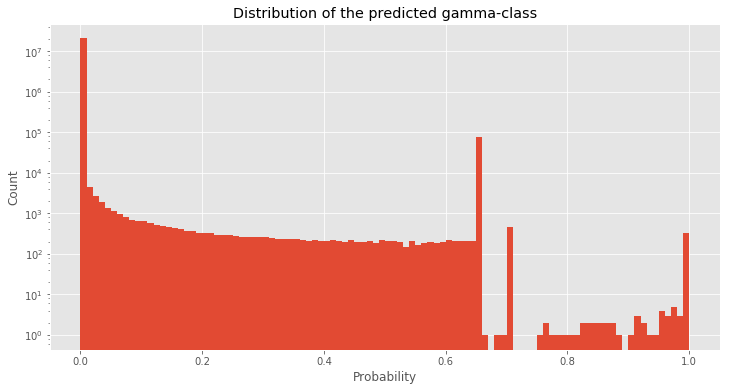

In [41]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))
plt.style.use('ggplot')
ax = fig.add_subplot(1,1,1)
plt.hist(gammas, bins=100)
plt.title('Distribution of the predicted gamma-class')
plt.xlabel('Probability')
plt.ylabel('Count')
ax.set_yscale('log')
plt.show()

In [51]:
probs = []
for i in np.arange(0,1,0.001):
    probs.append(len(gammas[gammas>i]))

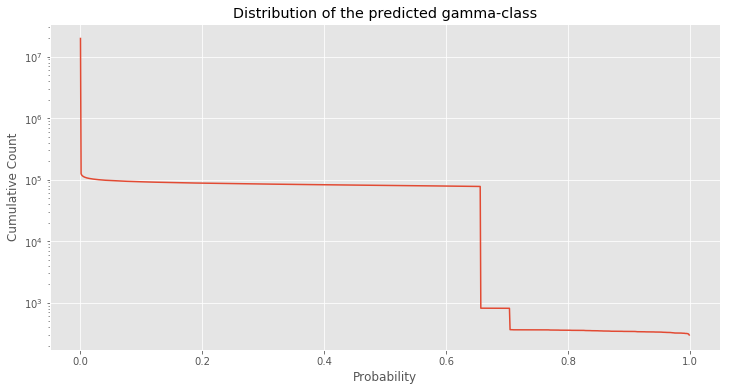

In [55]:
fig = plt.figure(figsize=(12,6))
plt.style.use('ggplot')
ax = fig.add_subplot(1,1,1)
plt.plot(np.arange(0,1,0.001), probs)
plt.title('Distribution of the predicted gamma-class')
plt.xlabel('Probability')
plt.ylabel('Cumulative Count')
ax.set_yscale('log')
plt.show()